In [7]:
# ==================== 1. CHARGEMENT DES DONNÉES (KAGGLE) ====================

import os
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import hashlib
from collections import defaultdict

print(f"TensorFlow version : {tf.__version__}")
print(f"GPU disponible : {tf.config.list_physical_devices('GPU')}")

# Chemins Kaggle
KAGGLE_INPUT_PATH = "/kaggle/input/utkface-new"  # Dataset d'entrée
OUTPUT_PATH = "/kaggle/working"  # Dossier de sortie pour les fichiers générés

# Trouver automatiquement le dossier contenant les images
possible_folders = ["UTKFace", "utkface_aligned_cropped", "crop_part1", ""]
image_folder = None

for folder in possible_folders:
    test_path = os.path.join(KAGGLE_INPUT_PATH, folder) if folder else KAGGLE_INPUT_PATH
    if os.path.exists(test_path):
        files = os.listdir(test_path)
        jpg_files = [f for f in files if f.endswith(".jpg")]
        if jpg_files:
            image_folder = test_path
            print(f"Dossier d'images trouvé : {image_folder}")
            break

if image_folder is None:
    raise FileNotFoundError("Impossible de trouver le dossier contenant les images UTKFace. Vérifiez que le dataset 'jangedoo/utkface-new' est ajouté au notebook.")

image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
print(f"Nombre de fichiers .jpg trouvés : {len(image_files)}")

images = []
labels = []

for file in image_files:
    try:
        parts = file.split("_")
        age = int(parts[0])
        gender = int(parts[1])
        try:
            race = int(parts[2])
        except:
            race = 4

        # Conversion en niveaux de gris et redimensionnement 128x128
        img = Image.open(os.path.join(image_folder, file)).convert("L").resize((128, 128))
        images.append(np.array(img))
        labels.append([age, gender, race])
    except:
        continue

images = np.array(images)
labels = np.array(labels)
print(f"Images chargées : {len(images)}")
print(f"Shape des images : {images.shape}")

# Extraire les variables démographiques
ages = labels[:, 0]
genders = labels[:, 1]
ethnicities = labels[:, 2]

print(f"\nStatistiques:")
print(f"Total d'images: {len(ages)}")
print(f"Âge: min={ages.min()}, max={ages.max()}")
print(f"Genre: {np.bincount(genders.astype(int))}")
print(f"Ethnicité: {np.bincount(ethnicities.astype(int))}")

TensorFlow version : 2.19.0
GPU disponible : []
Dossier d'images trouvé : /kaggle/input/utkface-new/UTKFace
Nombre de fichiers .jpg trouvés : 23708
Images chargées : 23708
Shape des images : (23708, 128, 128)

Statistiques:
Total d'images: 23708
Âge: min=1, max=116
Genre: [12391 11317]
Ethnicité: [10078  4526  3434  3975  1695]


In [8]:
# ==================== 2. TRAIN/TEST SPLIT ====================

# Ajouter une dimension pour le canal (niveaux de gris = 1 canal)
X = images.reshape(images.shape[0], 128, 128, 1)
print(f"Shape après reshape : {X.shape}")

# Split train/test (80/20) pour toutes les tâches
X_train, X_test, train_age, test_age, train_gender, test_gender, train_race, test_race = train_test_split(
    X, ages, genders, ethnicities,
    test_size=0.2,
    random_state=42,
    stratify=genders
)

# Normalisation simple /255
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"\nX_train min/max : {X_train.min():.2f} / {X_train.max():.2f}")
print(f"Train images: {X_train.shape}")
print(f"Test images: {X_test.shape}")
print(f"Train age: {train_age.shape}")
print(f"Train gender: {train_gender.shape}")
print(f"Train race: {train_race.shape}")
print(f"Test age: {test_age.shape}")
print(f"Test gender: {test_gender.shape}")
print(f"Test race: {test_race.shape}")
print("✓ Split train/test terminé!")

Shape après reshape : (23708, 128, 128, 1)

X_train min/max : 0.00 / 1.00
Train images: (18966, 128, 128, 1)
Test images: (4742, 128, 128, 1)
Train age: (18966,)
Train gender: (18966,)
Train race: (18966,)
Test age: (4742,)
Test gender: (4742,)
Test race: (4742,)
✓ Split train/test terminé!


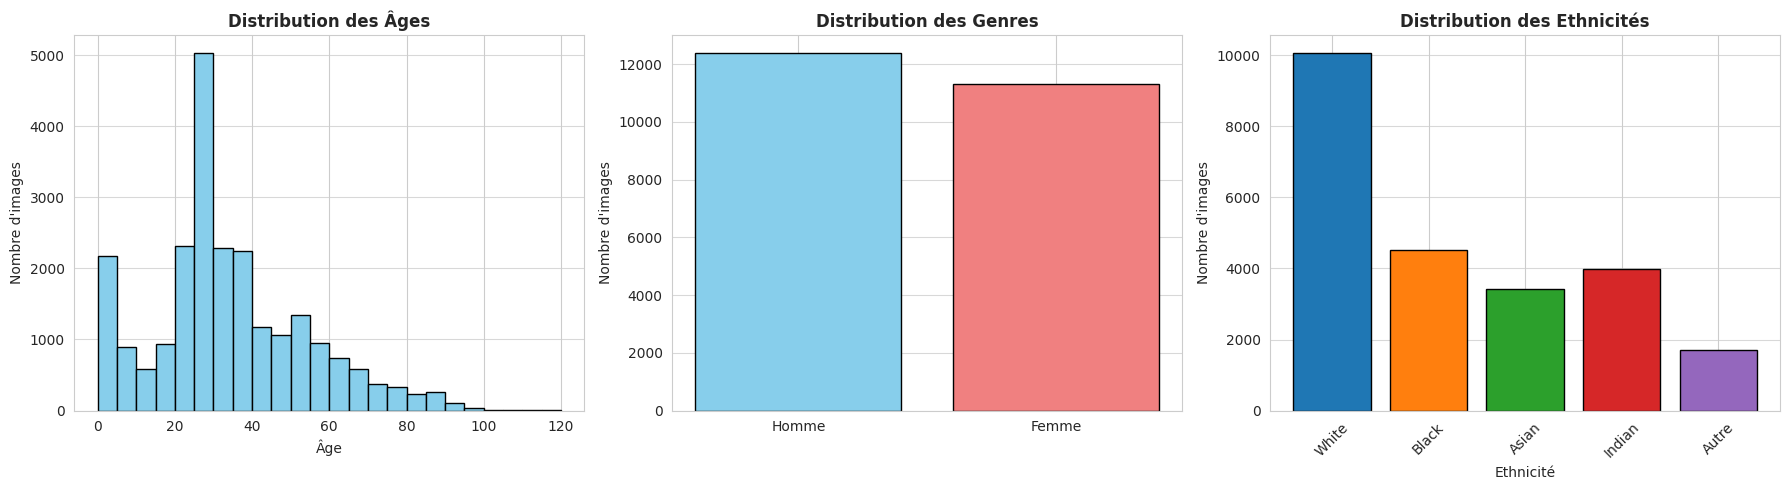

In [9]:
# ==================== 3. VISUALISATIONS UNIVARIÉES ====================
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution des âges
axes[0].hist(ages, bins=range(0, int(ages.max()) + 5, 5), edgecolor='black', color='skyblue')
axes[0].set_title('Distribution des Âges', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Âge')
axes[0].set_ylabel("Nombre d'images")
axes[0].grid(axis='y', alpha=0.75)

# Distribution des genres
gender_counts = np.bincount(genders.astype(int))
gender_labels = ['Homme', 'Femme']
axes[1].bar(gender_labels, gender_counts, color=['skyblue', 'lightcoral'], edgecolor='black')
axes[1].set_title('Distribution des Genres', fontsize=12, fontweight='bold')
axes[1].set_ylabel("Nombre d'images")
axes[1].grid(axis='y', alpha=0.75)

# Distribution des ethnicités
ethnicity_counts = np.bincount(ethnicities.astype(int))
ethnicity_labels = ['White', 'Black', 'Asian', 'Indian', 'Autre']
axes[2].bar(ethnicity_labels, ethnicity_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], edgecolor='black')
axes[2].set_title('Distribution des Ethnicités', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Ethnicité')
axes[2].set_ylabel("Nombre d'images")
axes[2].grid(axis='y', alpha=0.75)
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

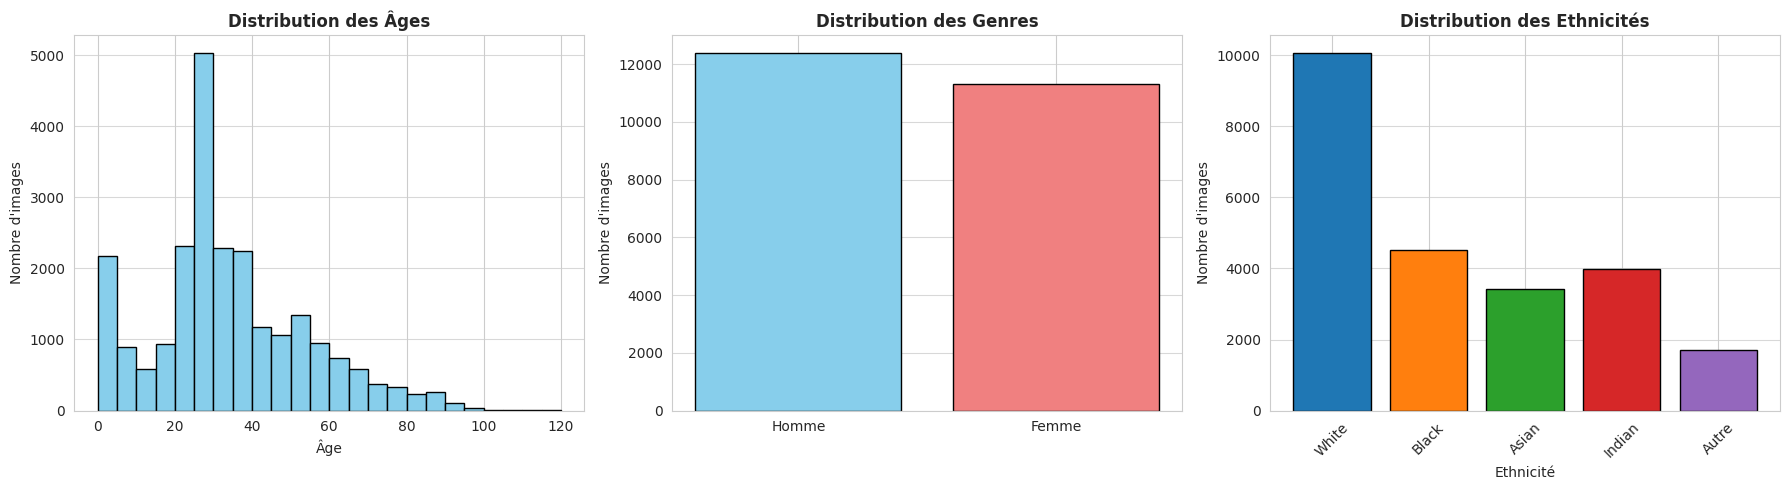

In [10]:
# Visualisation 1: Distributions univariées (Âge, Genre, Ethnicité)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution des âges
axes[0].hist(ages, bins=range(0, int(ages.max()) + 5, 5), edgecolor='black', color='skyblue')
axes[0].set_title('Distribution des Âges', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Âge')
axes[0].set_ylabel("Nombre d'images")
axes[0].grid(axis='y', alpha=0.75)

# Distribution des genres
gender_counts = np.bincount(genders)
gender_labels = ['Homme', 'Femme']
axes[1].bar(gender_labels, gender_counts, color=['skyblue', 'lightcoral'], edgecolor='black')
axes[1].set_title('Distribution des Genres', fontsize=12, fontweight='bold')
axes[1].set_ylabel("Nombre d'images")
axes[1].grid(axis='y', alpha=0.75)

# Distribution des ethnicités
ethnicity_counts = np.bincount(ethnicities)
ethnicity_labels = ['White', 'Black', 'Asian', 'Indian', 'Autre']
axes[2].bar(ethnicity_labels, ethnicity_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], edgecolor='black')
axes[2].set_title('Distribution des Ethnicités', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Ethnicité')
axes[2].set_ylabel("Nombre d'images")
axes[2].grid(axis='y', alpha=0.75)
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

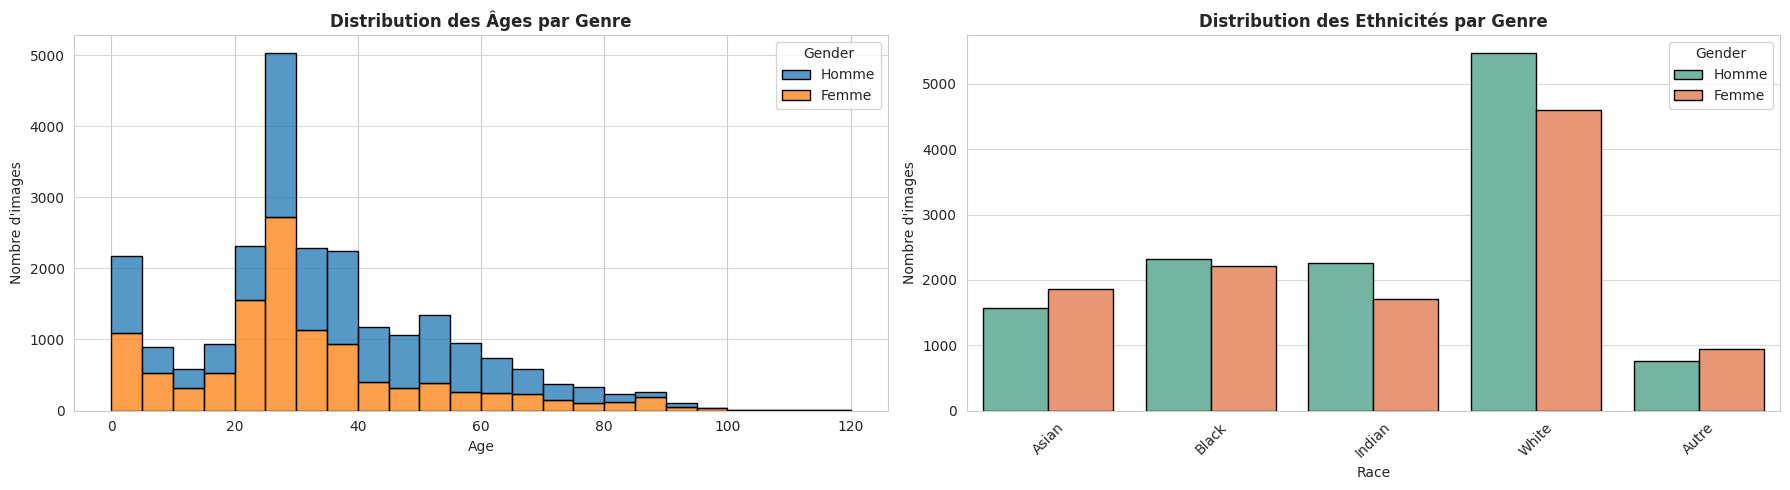

In [11]:
# Visualisation 2: Distributions croisées (Âge×Genre, Ethnicité×Genre)
df_full = pd.DataFrame({
    'Age': ages,
    'Gender': genders,
    'Race': ethnicities
})
df_full['Gender'] = df_full['Gender'].map({0: 'Homme', 1: 'Femme'})
df_full['Race'] = df_full['Race'].map({0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Autre'})

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Distribution des âges par genre
sns.histplot(data=df_full, x='Age', hue='Gender', multiple='stack', bins=range(0, int(ages.max()) + 5, 5), edgecolor='black', ax=axes[0])
axes[0].set_title('Distribution des Âges par Genre', fontsize=12, fontweight='bold')
axes[0].set_ylabel("Nombre d'images")
axes[0].grid(axis='y', alpha=0.75)

# Distribution des ethnicités par genre
sns.countplot(data=df_full, x='Race', hue='Gender', palette='Set2', edgecolor='black', ax=axes[1])
axes[1].set_title('Distribution des Ethnicités par Genre', fontsize=12, fontweight='bold')
axes[1].set_ylabel("Nombre d'images")
axes[1].grid(axis='y', alpha=0.75)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

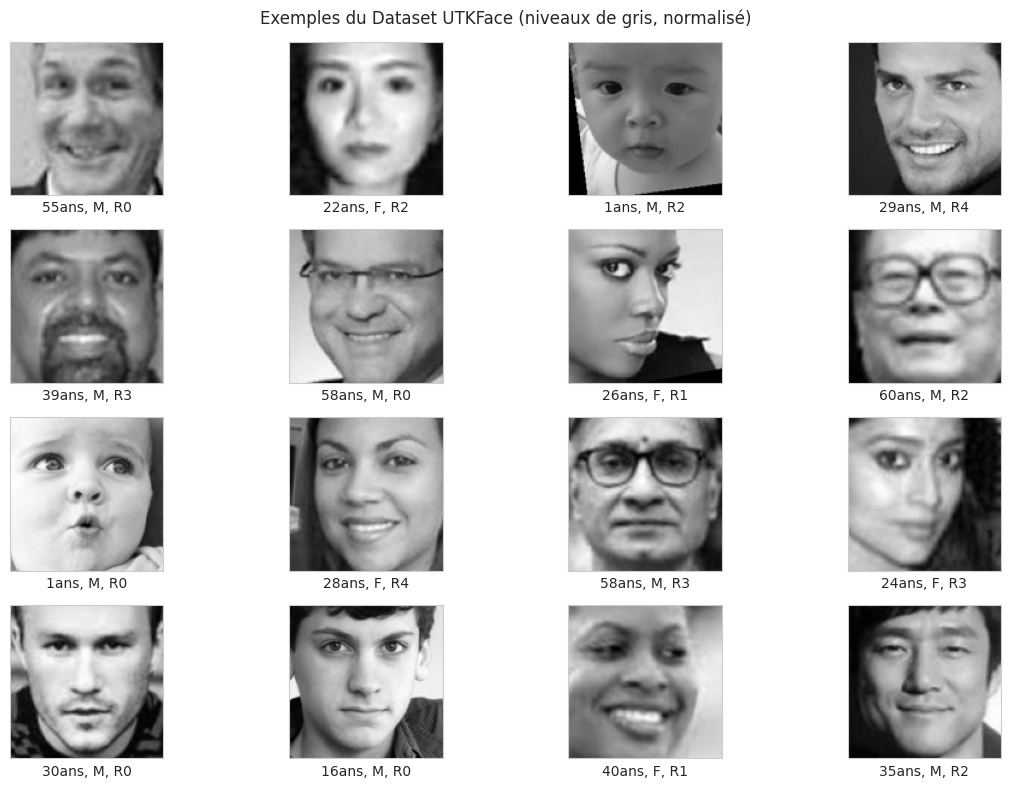

In [12]:
# Visualisation de quelques exemples du dataset (niveaux de gris)
plt.figure(figsize=(12, 8))
for i in range(min(16, len(X_train))):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Afficher l'image en niveaux de gris
    plt.imshow(X_train[i].reshape(128, 128), cmap='gray')
    # Affichage des labels
    age = int(train_age[i])
    gender = "M" if int(train_gender[i]) == 0 else "F"
    race = int(train_race[i])
    plt.xlabel(f"{age}ans, {gender}, R{race}")
plt.suptitle("Exemples du Dataset UTKFace (niveaux de gris, normalisé)")
plt.tight_layout()
plt.show()

In [13]:
# Détection des images en noir et blanc
# Note: Toutes les images sont en niveaux de gris (1 canal) donc 100% N&B
print("="*60)
print("COMPTAGE IMAGES NOIR & BLANC vs COULEURS")
print("="*60)

print(f"\nRésultats:")
print(f"  Total d'images: {len(images)}")
print(f"  Images en NOIR & BLANC: {len(images)} (100.00%)")
print(f"  Images en COULEURS: 0 (0.00%)")
print(f"\nNote: Les images ont été converties en niveaux de gris lors du chargement.")

COMPTAGE IMAGES NOIR & BLANC vs COULEURS

Résultats:
  Total d'images: 23708
  Images en NOIR & BLANC: 23708 (100.00%)
  Images en COULEURS: 0 (0.00%)

Note: Les images ont été converties en niveaux de gris lors du chargement.


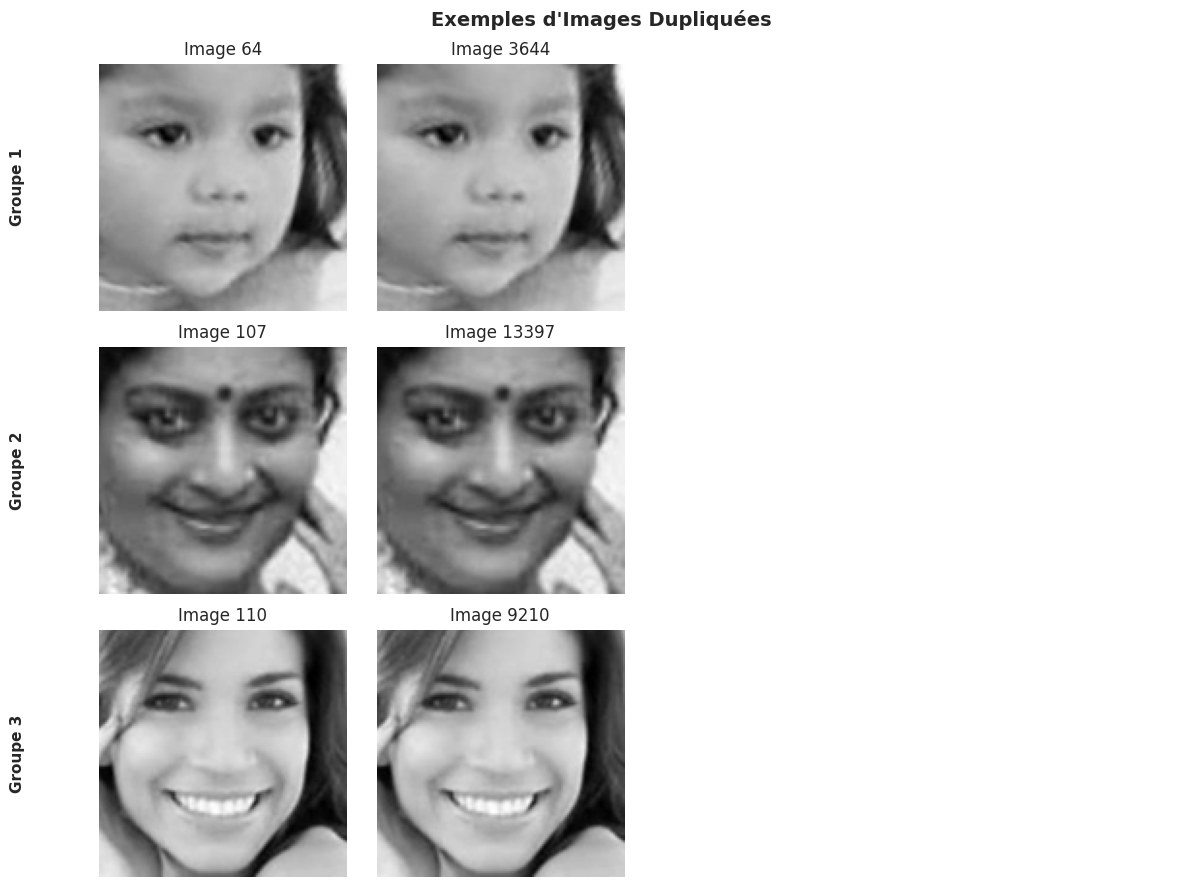

In [14]:
# Visualisation des duplicates (si trouvés)
import hashlib
from collections import defaultdict

image_hashes = defaultdict(list)

for idx, img in enumerate(images):
    img_hash = hashlib.md5(img.tobytes()).hexdigest()
    image_hashes[img_hash].append(idx)

duplicates = {k: v for k, v in image_hashes.items() if len(v) > 1}

if len(duplicates) > 0:
    n_groups = min(3, len(duplicates))
    fig, axes = plt.subplots(n_groups, 4, figsize=(12, 3*n_groups))

    if n_groups == 1:
        axes = axes.reshape(1, -1)

    for i, (hash_val, indices) in enumerate(list(duplicates.items())[:n_groups]):
        for j in range(4):
            if j < len(indices):
                idx = indices[j]
                axes[i, j].imshow(images[idx], cmap='gray')
                axes[i, j].set_title(f"Image {idx}")
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')

        axes[i, 0].text(-0.3, 0.5, f'Groupe {i+1}',
                       transform=axes[i, 0].transAxes,
                       fontsize=11, fontweight='bold',
                       va='center', ha='right', rotation=90)

    plt.suptitle('Exemples d\'Images Dupliquées', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Aucun duplicate à visualiser.")

In [15]:
# Détection de duplicates avec hash MD5
import hashlib
from collections import defaultdict

print("="*60)
print("DÉTECTION D'IMAGES DUPLIQUÉES")
print("="*60)

print("\nCalcul des hash pour toutes les images...")

image_hashes = defaultdict(list)

for idx, img in enumerate(images):
    # Calculer le hash MD5 de l'image
    img_hash = hashlib.md5(img.tobytes()).hexdigest()
    image_hashes[img_hash].append(idx)

# Trouver les duplicates
duplicates = {k: v for k, v in image_hashes.items() if len(v) > 1}
n_duplicates = sum(len(v) - 1 for v in duplicates.values())

print(f"\nRésultats:")
print(f"  Total d'images analysées: {len(images)}")
print(f"  Nombre total d'images dupliquées (au-delà de la première instance): {n_duplicates}")
print(f"  Nombre de groupes d'images dupliquées: {len(duplicates)}")

if len(duplicates) > 0:
    print(f"\n  Détail de toutes les images dupliquées (par hash et indices):")
    for i, (hash_val, indices) in enumerate(duplicates.items()):
        print(f"    Groupe {i+1} (Hash: {hash_val[:8]}...): {len(indices)} images identiques (indices: {indices})")
else:
    print("\n✅ Aucune image dupliquée trouvée!")

DÉTECTION D'IMAGES DUPLIQUÉES

Calcul des hash pour toutes les images...

Résultats:
  Total d'images analysées: 23708
  Nombre total d'images dupliquées (au-delà de la première instance): 390
  Nombre de groupes d'images dupliquées: 375

  Détail de toutes les images dupliquées (par hash et indices):
    Groupe 1 (Hash: 70165498...): 2 images identiques (indices: [64, 3644])
    Groupe 2 (Hash: 2c8038f9...): 2 images identiques (indices: [107, 13397])
    Groupe 3 (Hash: 7870c1a0...): 2 images identiques (indices: [110, 9210])
    Groupe 4 (Hash: 8d50a6dd...): 2 images identiques (indices: [173, 1303])
    Groupe 5 (Hash: 7de84e93...): 3 images identiques (indices: [196, 4677, 11594])
    Groupe 6 (Hash: 889b225c...): 2 images identiques (indices: [291, 8211])
    Groupe 7 (Hash: 1b2d5d48...): 2 images identiques (indices: [308, 15068])
    Groupe 8 (Hash: f72ca226...): 2 images identiques (indices: [320, 4800])
    Groupe 9 (Hash: 5de4c32d...): 2 images identiques (indices: [372, 121

In [16]:
# Création du modèle CNN (style Cours 5)
# Remarque : architecture adaptée pour images en niveaux de gris (1 canal)

def build_gender_cnn(input_shape=(128, 128, 1)):
    """Construit un CNN simple pour classifier le genre (0/1)."""
    model = Sequential([
        # Bloc conv 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        # Bloc conv 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Bloc conv 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Classification
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # sortie binaire
    ])

    # Compilation
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model_gender = build_gender_cnn(input_shape=X_train.shape[1:])
model_gender.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,233 (16.35 MB)

 Trainable params: 4,287,233 (16.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entraînement du modèle
# Simple et lisible : quelques epochs + validation sur le test.

EPOCHS = 5
BATCH_SIZE = 32

history_gender = model_gender.fit(
    X_train,
    train_gender,
    validation_data=(X_test, test_gender),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 744s 1s/step - accuracy: 0.7076 - loss: 0.5463 - val_accuracy: 0.8499 - val_loss: 0.3335
Epoch 2/5
253/593 ━━━━━━━━━━━━━━━━━━━━ 6:23 1s/step - accuracy: 0.8557 - loss: 0.3263

In [ ]:
# Étude simple du modèle : courbes d'apprentissage
acc = history_gender.history.get('accuracy', [])
val_acc = history_gender.history.get('val_accuracy', [])
loss = history_gender.history.get('loss', [])
val_loss = history_gender.history.get('val_loss', [])

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train')
plt.plot(epochs_range, val_acc, label='Test')
plt.title("Accuracy - Genre")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train')
plt.plot(epochs_range, val_loss, label='Test')
plt.title("Loss - Genre")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Évaluation simple : accuracy + matrice de confusion

y_proba = model_gender.predict(X_test, verbose=0).reshape(-1)
y_pred = (y_proba >= 0.5).astype(int)

test_acc = (y_pred == test_gender.astype(int)).mean()
print(f"Accuracy sur le test: {test_acc*100:.2f}%")

cm = confusion_matrix(test_gender.astype(int), y_pred)
print("\nMatrice de confusion (format sklearn):")
print(cm)

print("\nRapport de classification:")
print(classification_report(test_gender.astype(int), y_pred, target_names=['Homme(0)', 'Femme(1)']))

# Affichage graphique de la matrice de confusion
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Homme(0)', 'Femme(1)'],
            yticklabels=['Homme(0)', 'Femme(1)'])
plt.title('Matrice de confusion - Modèle Genre')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.tight_layout()
plt.show()